# Image Captioning
Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.

## Importing 

In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [7]:
image_path="/kaggle/input/flickr8k/Images"

In [9]:
data=pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
def readImage(path,img_size=224):
    img=load_img(path,color_mode='rgb',target_size=(img_size,img_size), interpolation='bilinear')
    img=img_to_array(img)
    img=img/255
    return img

In [11]:
def display_images(temp_df):
    temp_df=temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i],20)))
        plt.axis('off')

## Visualization

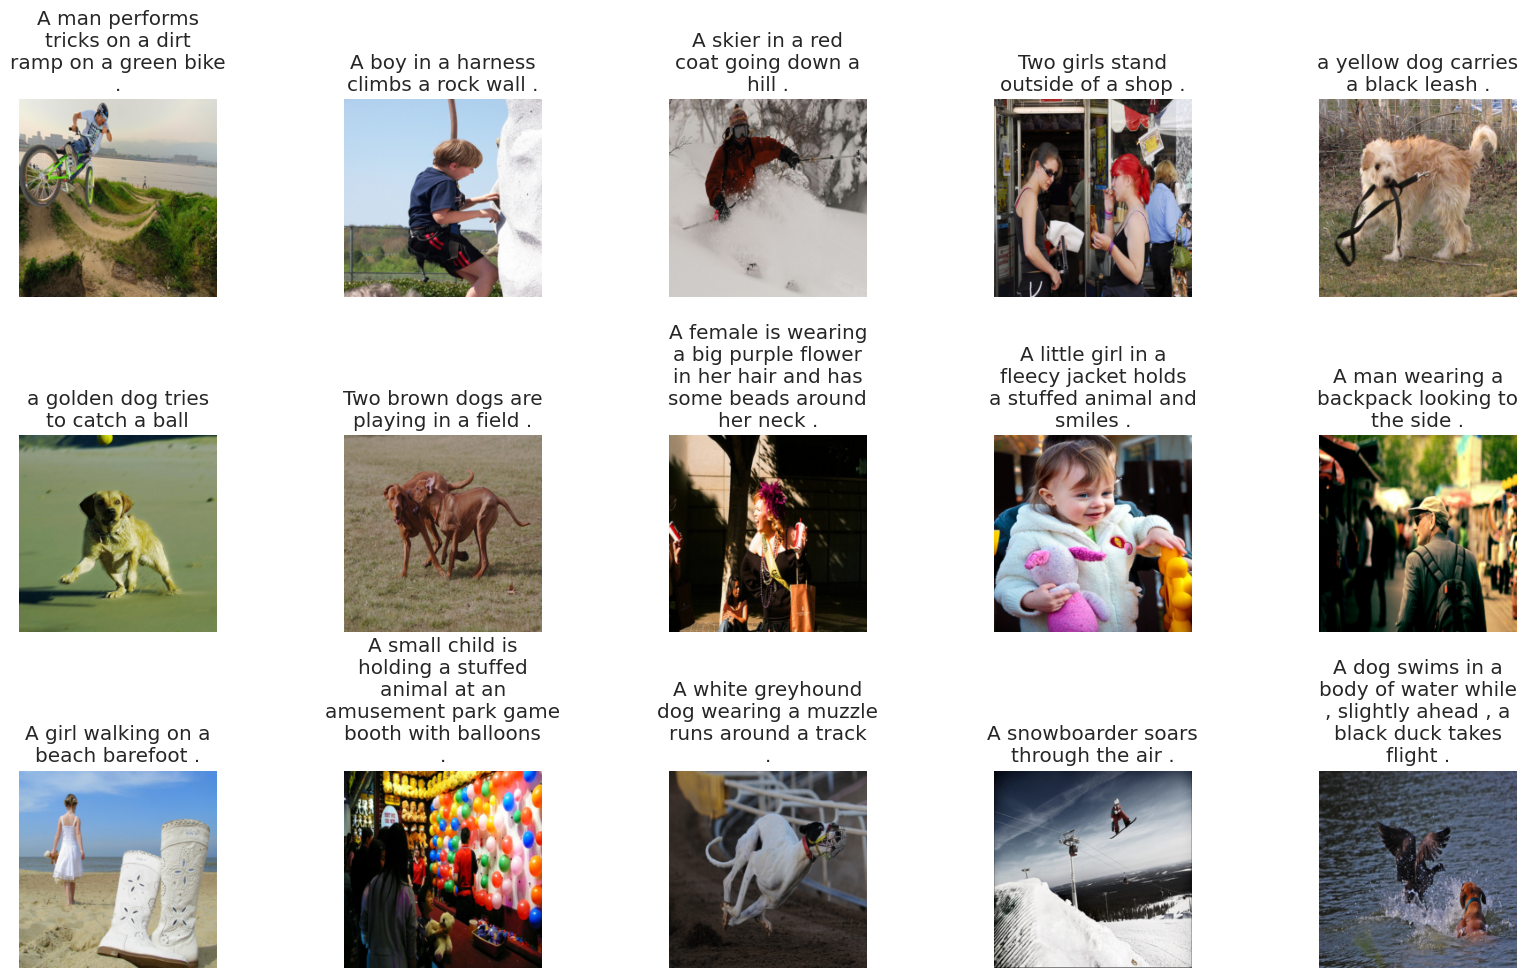

In [12]:
display_images(data.sample(15))

## Text Preprocessing
. Convert sentences into lowercase.

. Remove special characters and numbers present in the text.

. Remove extra spaces.

. Remove single Characters.

. Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence.

In [13]:
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].str.replace(r"[^a-z\s]", "", regex=True)  # Remove non-alphabet characters
    data['caption'] = data['caption'].str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with a single space
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))  # Remove single-letter words
    data['caption'] = data['caption'].apply(lambda x: f"startseq {x.strip()} endseq")  # Add sequence tokens
    return data


In [14]:
# //example
string = pd.DataFrame(["Hello, World! 1234"],columns=['caption'])
text_preprocessing(string)
string

,caption
0,startseq hello world endseq


## Preprocessed Text

In [15]:
data=text_preprocessing(data)
captions=data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation.

### Difference Between Tokenization and Word Embedding

### 1. Tokenization  
Tokenization is the process of splitting text into smaller units (tokens), which can be words, subwords, or characters.

#### **Purpose:**  
- It prepares raw text for further processing by breaking it into meaningful units.

#### **Types of Tokenization:**
- **Word-level Tokenization:** Splitting text into words.  
  Example: `"Hello, world!" \rightarrow ["Hello", ",", "world", "!"]`
- **Subword Tokenization:** Breaking words into meaningful subunits.  
  Example: `"playing" \rightarrow ["play", "ing"]`
- **Character-level Tokenization:** Splitting text into individual characters.  
  Example: `"cat" \rightarrow ["c", "a", "t"]`

#### **Example**
Let’s say we have the sentence:  
\[
\text{"I love NLP."}
\]
After tokenization, it becomes:  
\[
["I", "love", "NLP", "."]
\]

---

### 2. Word Embedding  
Word embedding is the process of converting words or tokens into dense numerical vectors that represent their meaning.

#### **Purpose:**  
- It enables machine learning models to understand semantic relationships between words.

#### **Types of Word Embedding:**
1. **One-hot Encoding:** A sparse representation where each word is mapped to a unique binary vector.
2. **Word2Vec:** Uses context to learn vector representations (CBOW, Skip-gram).
3. **GloVe:** Captures word co-occurrence statistics in a corpus.
4. **FastText:** Extends Word2Vec with subword information.
5. **Transformer-based Embeddings:** (e.g., BERT, GPT) generate contextualized word embeddings.

#### **Example**  
Let’s say we have the word **"cat"**, its corresponding word embedding could be:  
\[
\text{"cat"} \rightarrow [0.2, -0.1, 0.7, ..., 0.5]
\]

---

### **Key Differences Between Tokenization and Word Embedding**
\[
\begin{array}{|c|c|c|}
\hline
\textbf{Feature} & \textbf{Tokenization} & \textbf{Word Embedding} \\
\hline
\text{Purpose} & \text{Splits text into tokens} & \text{Converts tokens into vector representations} \\
\hline
\text{Output} & \text{A list of tokens} & \text{Dense numerical vectors} \\
\hline
\text{Type of Data} & \text{Text (words, subwords, characters)} & \text{Numerical representations} \\
\hline
\text{Use Case} & \text{Preprocessing for NLP tasks} & \text{Machine learning \& deep learning models} \\
\hline
\text{Examples} & \text{Word, subword, character tokenization} & \text{Word2Vec, GloVe, BERT embeddings} \\
\hline
\end{array}
\]

### **Conclusion**
- **Tokenization** is a preprocessing step that breaks text into tokens.
- **Word embedding** transforms these tokens into numerical representations that capture meaning and relationships.

---


In [16]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit tokenizer on the captions (builds vocabulary from captions)
tokenizer.fit_on_texts(captions)

# Compute vocabulary size (+1 to account for padding/unknown token)
vocab_size = len(tokenizer.word_index) + 1  

# Find the maximum length of any caption (longest sentence in terms of words)
max_length = max(len(caption.split()) for caption in captions)

# Extract unique image filenames from the dataset
images = data['image'].unique().tolist()

# Get the total number of unique images
nimages = len(images)

# Compute the index to split data (85% train, 15% validation)
split_index = round(0.85 * nimages)

# Split the image list into training and validation sets
train_images = images[:split_index]  # First 85% images for training
val_images = images[split_index:]  # Remaining 15% for validation

# Filter the dataset to create training and testing data
train = data[data['image'].isin(train_images)]  # Get rows where 'image' is in train_images
test = data[data['image'].isin(val_images)]  # Get rows where 'image' is in val_images

# Reset the index to avoid gaps after filtering
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Convert a specific caption (captions[1]) into a sequence of word indices
tokenized_caption = tokenizer.texts_to_sequences([captions[1]])[0]

# Print the tokenized caption to verify
print(tokenized_caption)


[1, 18, 312, 63, 192, 116, 2]


In [17]:
train.head()

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...


In [18]:
test.head()

,image,caption
0,3688858505_e8afd1475d.jpg,startseq blond girl in green dress and elabora...
1,3688858505_e8afd1475d.jpg,startseq few people with girl standing up in t...
2,3688858505_e8afd1475d.jpg,startseq girl is wear green dress endseq
3,3688858505_e8afd1475d.jpg,startseq blonde girl wearing green dress stand...
4,3688858505_e8afd1475d.jpg,startseq woman in green dress being observed e...


## Image Feature Extraction

we are using DenseNet201 Architecture to extract the features from the images.Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

In [19]:
model =DenseNet201()
#extracting features of images
fe=Model(inputs=model.input,outputs=model.layers[-2].output)

img_size=224
#to store features in a dict.
features={}

for image in tqdm(data['image'].unique().tolist()):
    img=load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img=img_to_array(img)
    img=img/255
    #tensroflow models take 4d image therefore adding one channel
    img=np.expand_dims(img,axis=0)
    feature=fe.predict(img,verbose=0)
    features[image]=feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [11:14<00:00, 12.00it/s]


## Data Generataion

The CustomDataGenerator class is a custom data loader that efficiently processes image-capiton paris for training.It:

. Loads image features and tokenizes captions.

. Converts captions into sequences and applies padding.

. Generates input-output pairs for training a deep learning model.

. Uses batch processing to optimize memory usage.

. Supports shuffling after each epoch for better learning.


In [20]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

## Modelling

. The image embedding representations are concatendated with the first word of sentence i.e. starseq and passed to the LSTM network.

. The LSTM network starts generating words after each input thus forming a sentence at the end

In [21]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [22]:
from tensorflow.keras.utils import plot_model

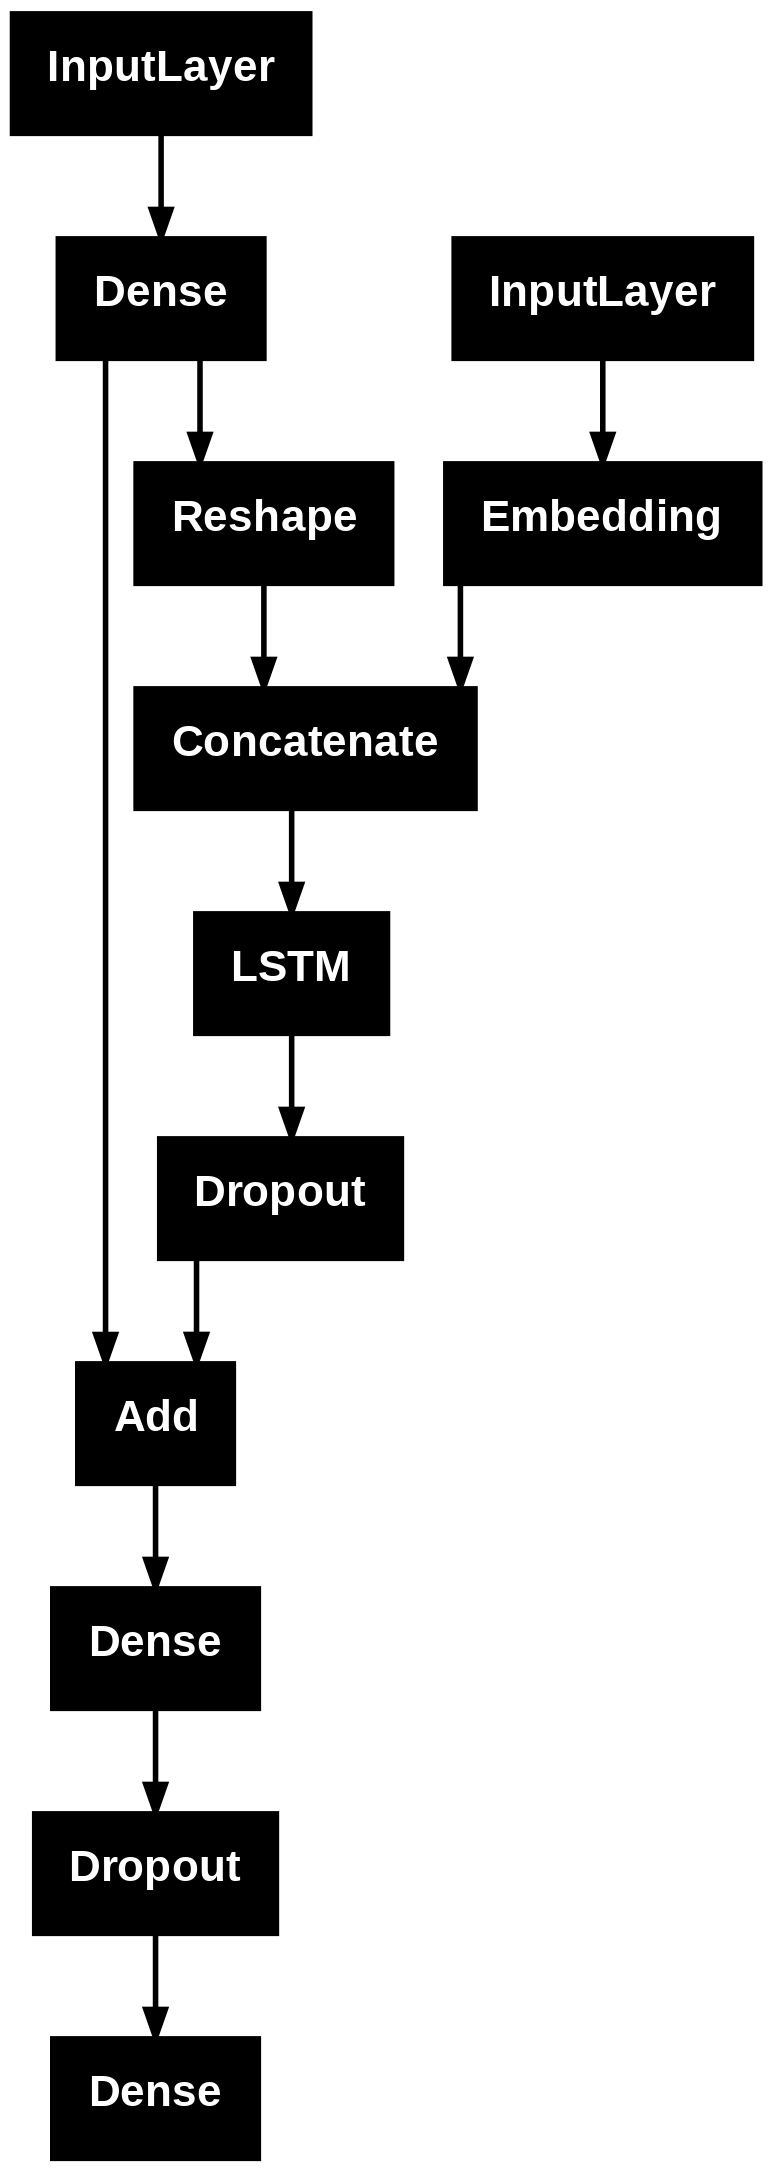

In [23]:
plot_model(caption_model)

In [24]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        491,776 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,244,608 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 35, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8768)           │      1,131,072 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,425,664 (16.88 MB)

 Trainable params: 4,425,664 (16.88 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [35]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [36]:
history = caption_model.fit(
        train_generator,
        epochs=80,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/80
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 3.2240
Epoch 1: val_loss improved from inf to 3.75030, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 289s 531ms/step - loss: 3.2240 - val_loss: 3.7503 - learning_rate: 1.0000e-08
Epoch 2/80
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.2224
Epoch 2: val_loss improved from 3.75030 to 3.74390, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - loss: 3.2223 - val_loss: 3.7439 - learning_rate: 1.0000e-08
Epoch 3/80
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 3.2042
Epoch 3: val_loss did not improve from 3.74390
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - loss: 3.2042 - val_loss: 3.7463 - learning_rate: 1.0000e-08
Epoch 4/80
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 3.2183
Epoch 4: val_loss did not improve from 3.74390
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 136ms/step - loss: 3.2183 - val_loss: 3.7478 - learning_rate: 1.0000e-08
Epoch 5/80
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/

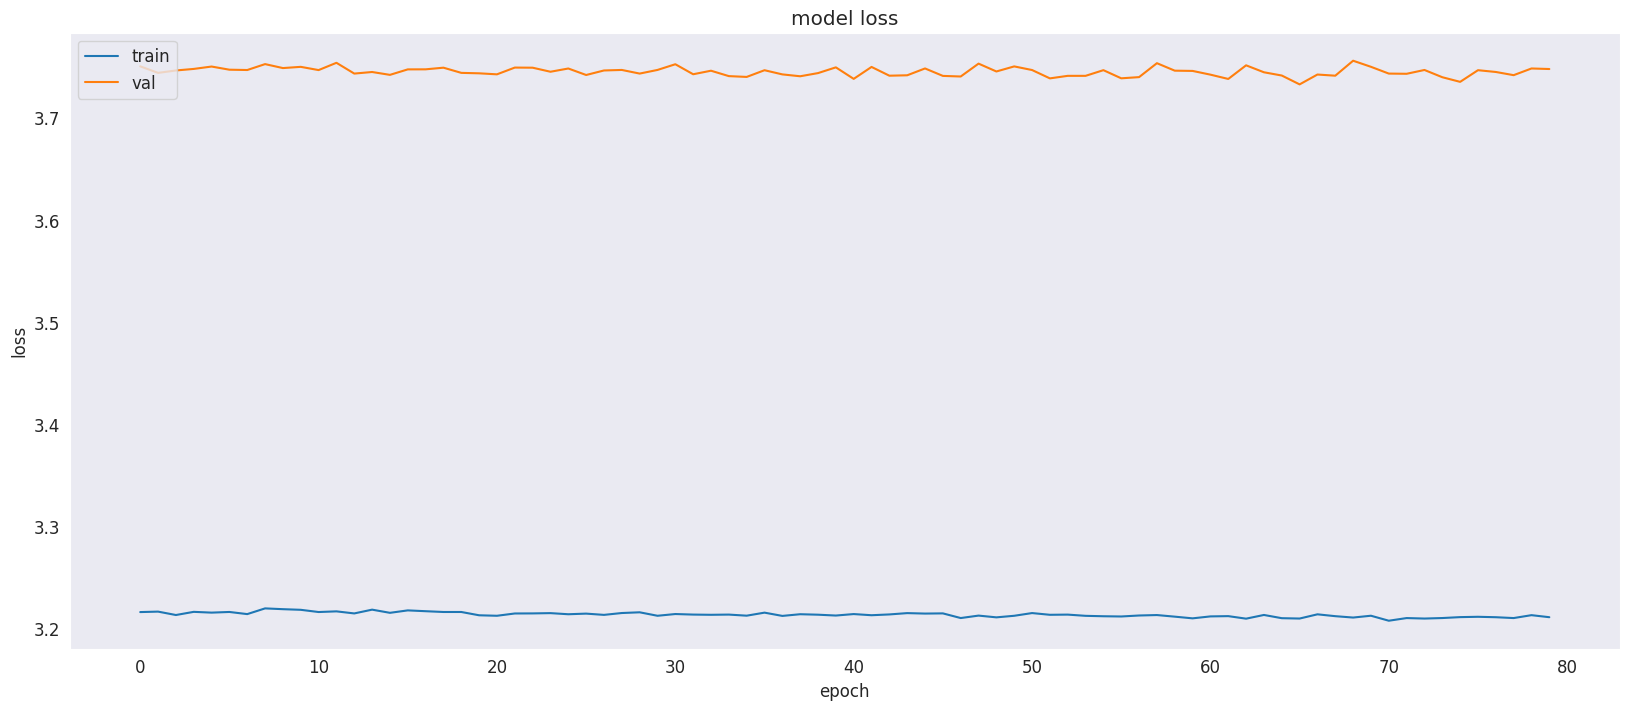

In [37]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
def idx_to_word(integer, tokenizer):
    return tokenizer.index_word.get(integer, None)


In [44]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text

In [45]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [46]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

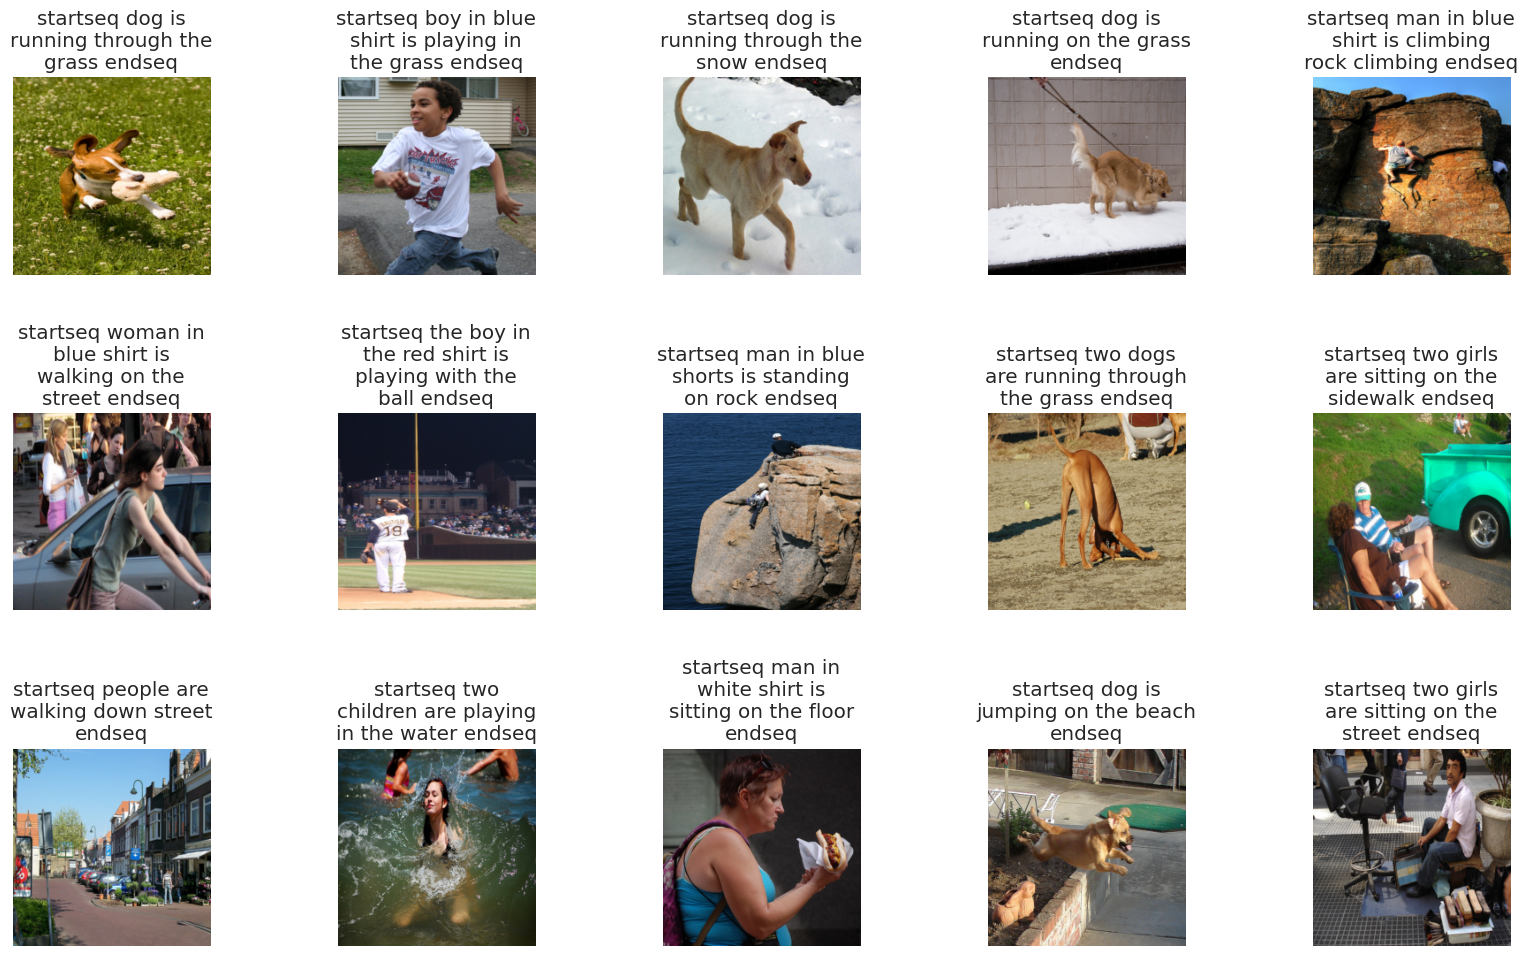

In [48]:
display_images(samples)
